In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_excel("./small_with_healthy.xlsx")
data.drop(columns="Unnamed: 0", inplace=True)
data.loc[data['диагноз клинический'] == 'healthy', 'grouped_diagnosis'] = 'healthy'

In [6]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
np.random.seed(42)

target_column = "grouped_diagnosis"  
le = LabelEncoder()
y = le.fit_transform(data[target_column])
X = data.drop(columns=[target_column])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

In [8]:
from catboost import CatBoostClassifier, Pool

loaded_model = CatBoostClassifier()
loaded_model.load_model('best_catboost_model.cbm')

In [63]:
def create_mean_patient(model, X, y, target_class, threshold=0.9):
    probas = model.predict_proba(X)
    high_conf_mask = (probas[:, target_class] > threshold) & (y == target_class)    
    print(f"{sum(high_conf_mask)} patients are used for class {target_class}")
    mean_patient = np.nanmean(X[high_conf_mask], axis=0)

    mean_patient = pd.DataFrame([mean_patient], 
                                columns=X.columns,
                                index=[le.classes_[target_class]])
    return mean_patient

mean_patients_list = []

for target_class in range(19): 
    mean_patient = create_mean_patient(
        model=loaded_model,
        X=X_val.drop(["client_id", "диагноз клинический"], axis=1),
        y=y_val,
        target_class=target_class
    )
    mean_patients_list.append(mean_patient)

mean_patients_df = pd.concat(mean_patients_list)
mean_patients_df.reset_index(inplace=True)
mean_patients_df.rename(columns={'index': 'target_class'}, inplace=True)
mean_patients_df.set_index("target_class").loc[["C90", "D50", "D69", "healthy"]
                                               ,['Гемоглобин[00001]', 'Лейкоциты[00010]'
                                                 , 'Тромбоциты[00015]','Эритроциты[00002]'
                                                 ,'Средний объем эритроцита[00004]', "Глобулин[1.11.1.51]"
                                                 , "Кальций общий[1.11.1.11]"]]



27 patients are used for class 0
10 patients are used for class 1
9 patients are used for class 2
12 patients are used for class 3
63 patients are used for class 4
57 patients are used for class 5
48 patients are used for class 6
54 patients are used for class 7
32 patients are used for class 8
43 patients are used for class 9


/scratch/ipykernel_3274824/726785129.py:5: RuntimeWarning: Mean of empty slice
  mean_patient = np.nanmean(X[high_conf_mask], axis=0)
/scratch/ipykernel_3274824/726785129.py:5: RuntimeWarning: Mean of empty slice
  mean_patient = np.nanmean(X[high_conf_mask], axis=0)
/scratch/ipykernel_3274824/726785129.py:5: RuntimeWarning: Mean of empty slice
  mean_patient = np.nanmean(X[high_conf_mask], axis=0)
/scratch/ipykernel_3274824/726785129.py:5: RuntimeWarning: Mean of empty slice
  mean_patient = np.nanmean(X[high_conf_mask], axis=0)
/scratch/ipykernel_3274824/726785129.py:5: RuntimeWarning: Mean of empty slice
  mean_patient = np.nanmean(X[high_conf_mask], axis=0)
/scratch/ipykernel_3274824/726785129.py:5: RuntimeWarning: Mean of empty slice
  mean_patient = np.nanmean(X[high_conf_mask], axis=0)
/scratch/ipykernel_3274824/726785129.py:5: RuntimeWarning: Mean of empty slice
  mean_patient = np.nanmean(X[high_conf_mask], axis=0)


53 patients are used for class 10
49 patients are used for class 11
40 patients are used for class 12
132 patients are used for class 13
14 patients are used for class 14
14 patients are used for class 15
14 patients are used for class 16
15 patients are used for class 17
19 patients are used for class 18


/scratch/ipykernel_3274824/726785129.py:5: RuntimeWarning: Mean of empty slice
  mean_patient = np.nanmean(X[high_conf_mask], axis=0)
/scratch/ipykernel_3274824/726785129.py:5: RuntimeWarning: Mean of empty slice
  mean_patient = np.nanmean(X[high_conf_mask], axis=0)
/scratch/ipykernel_3274824/726785129.py:5: RuntimeWarning: Mean of empty slice
  mean_patient = np.nanmean(X[high_conf_mask], axis=0)
/scratch/ipykernel_3274824/726785129.py:5: RuntimeWarning: Mean of empty slice
  mean_patient = np.nanmean(X[high_conf_mask], axis=0)


,Гемоглобин[00001],Лейкоциты[00010],Тромбоциты[00015],Эритроциты[00002],Средний объем эритроцита[00004],Глобулин[1.11.1.51],Кальций общий[1.11.1.11]
target_class,,,,,,,
C90,110.065574,7.035082,230.967213,3.587049,93.342623,53.245455,2.485323
D50,93.113208,6.071509,334.716981,4.358113,72.737736,29.314286,2.390833
D69,135.431818,8.070303,39.939394,4.753182,85.250000,29.671429,2.335750
healthy,139.857143,6.137143,263.428571,4.927857,85.957143,28.285714,2.435385


Here we can see that values of features are consistent with reality (and reference ranges) which was confirmed by our clinician

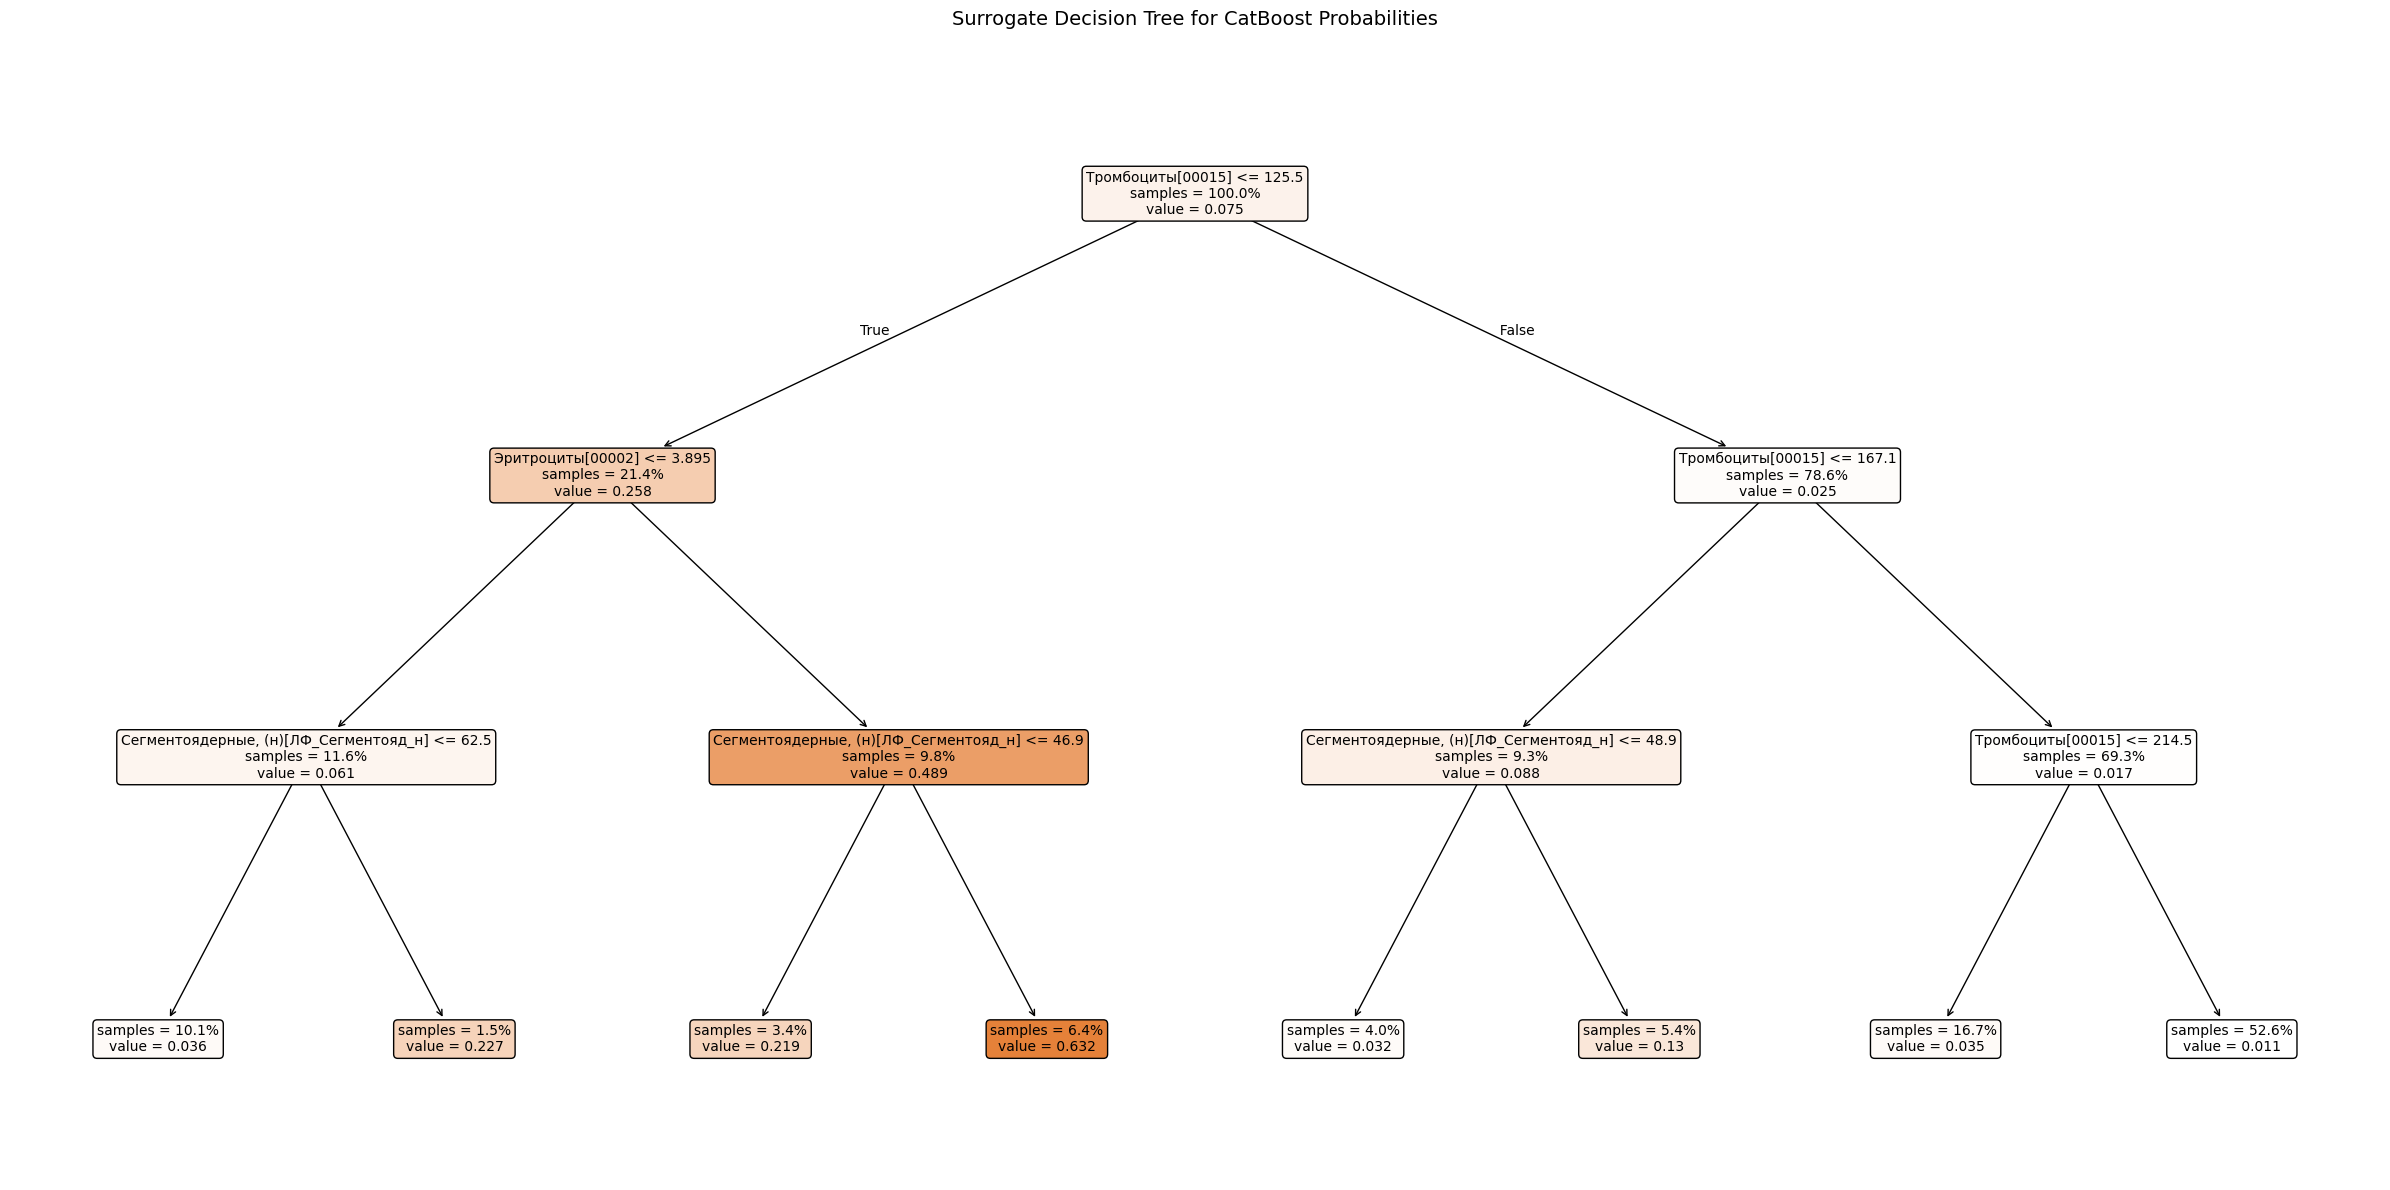

In [12]:
from sklearn.tree import plot_tree, DecisionTreeRegressor
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

imputer = KNNImputer(n_neighbors=5, weights='uniform')
X_train_imputed = imputer.fit_transform(X_train.drop(["client_id", "диагноз клинический"], axis=1))
X_val_imputed = imputer.transform(X_val.drop(["client_id", "диагноз клинический"], axis=1))

def surrogate_tree(X, target_class, column_names):
    X_proba = loaded_model.predict_proba(X)
    surrogate = DecisionTreeRegressor(
        max_depth=3, 
    )
    surrogate.fit(X, X_proba[:, target_class])

    plt.figure(figsize=(24, 12))
    plot_tree(
        surrogate,
        feature_names=column_names, 
        filled=True,
        rounded=True,
        proportion=True,
        fontsize=10,
        impurity=False
    )
    plt.title("Surrogate Decision Tree for CatBoost Probabilities", pad=20, fontsize=14)
    plt.tight_layout()
    plt.show()

surrogate_tree(X_val_imputed, 13, X_train.drop(["client_id", "диагноз клинический"], axis=1).columns) #class D69


Relying on trombocytes for thrombocytopenia diagnosis is correct 

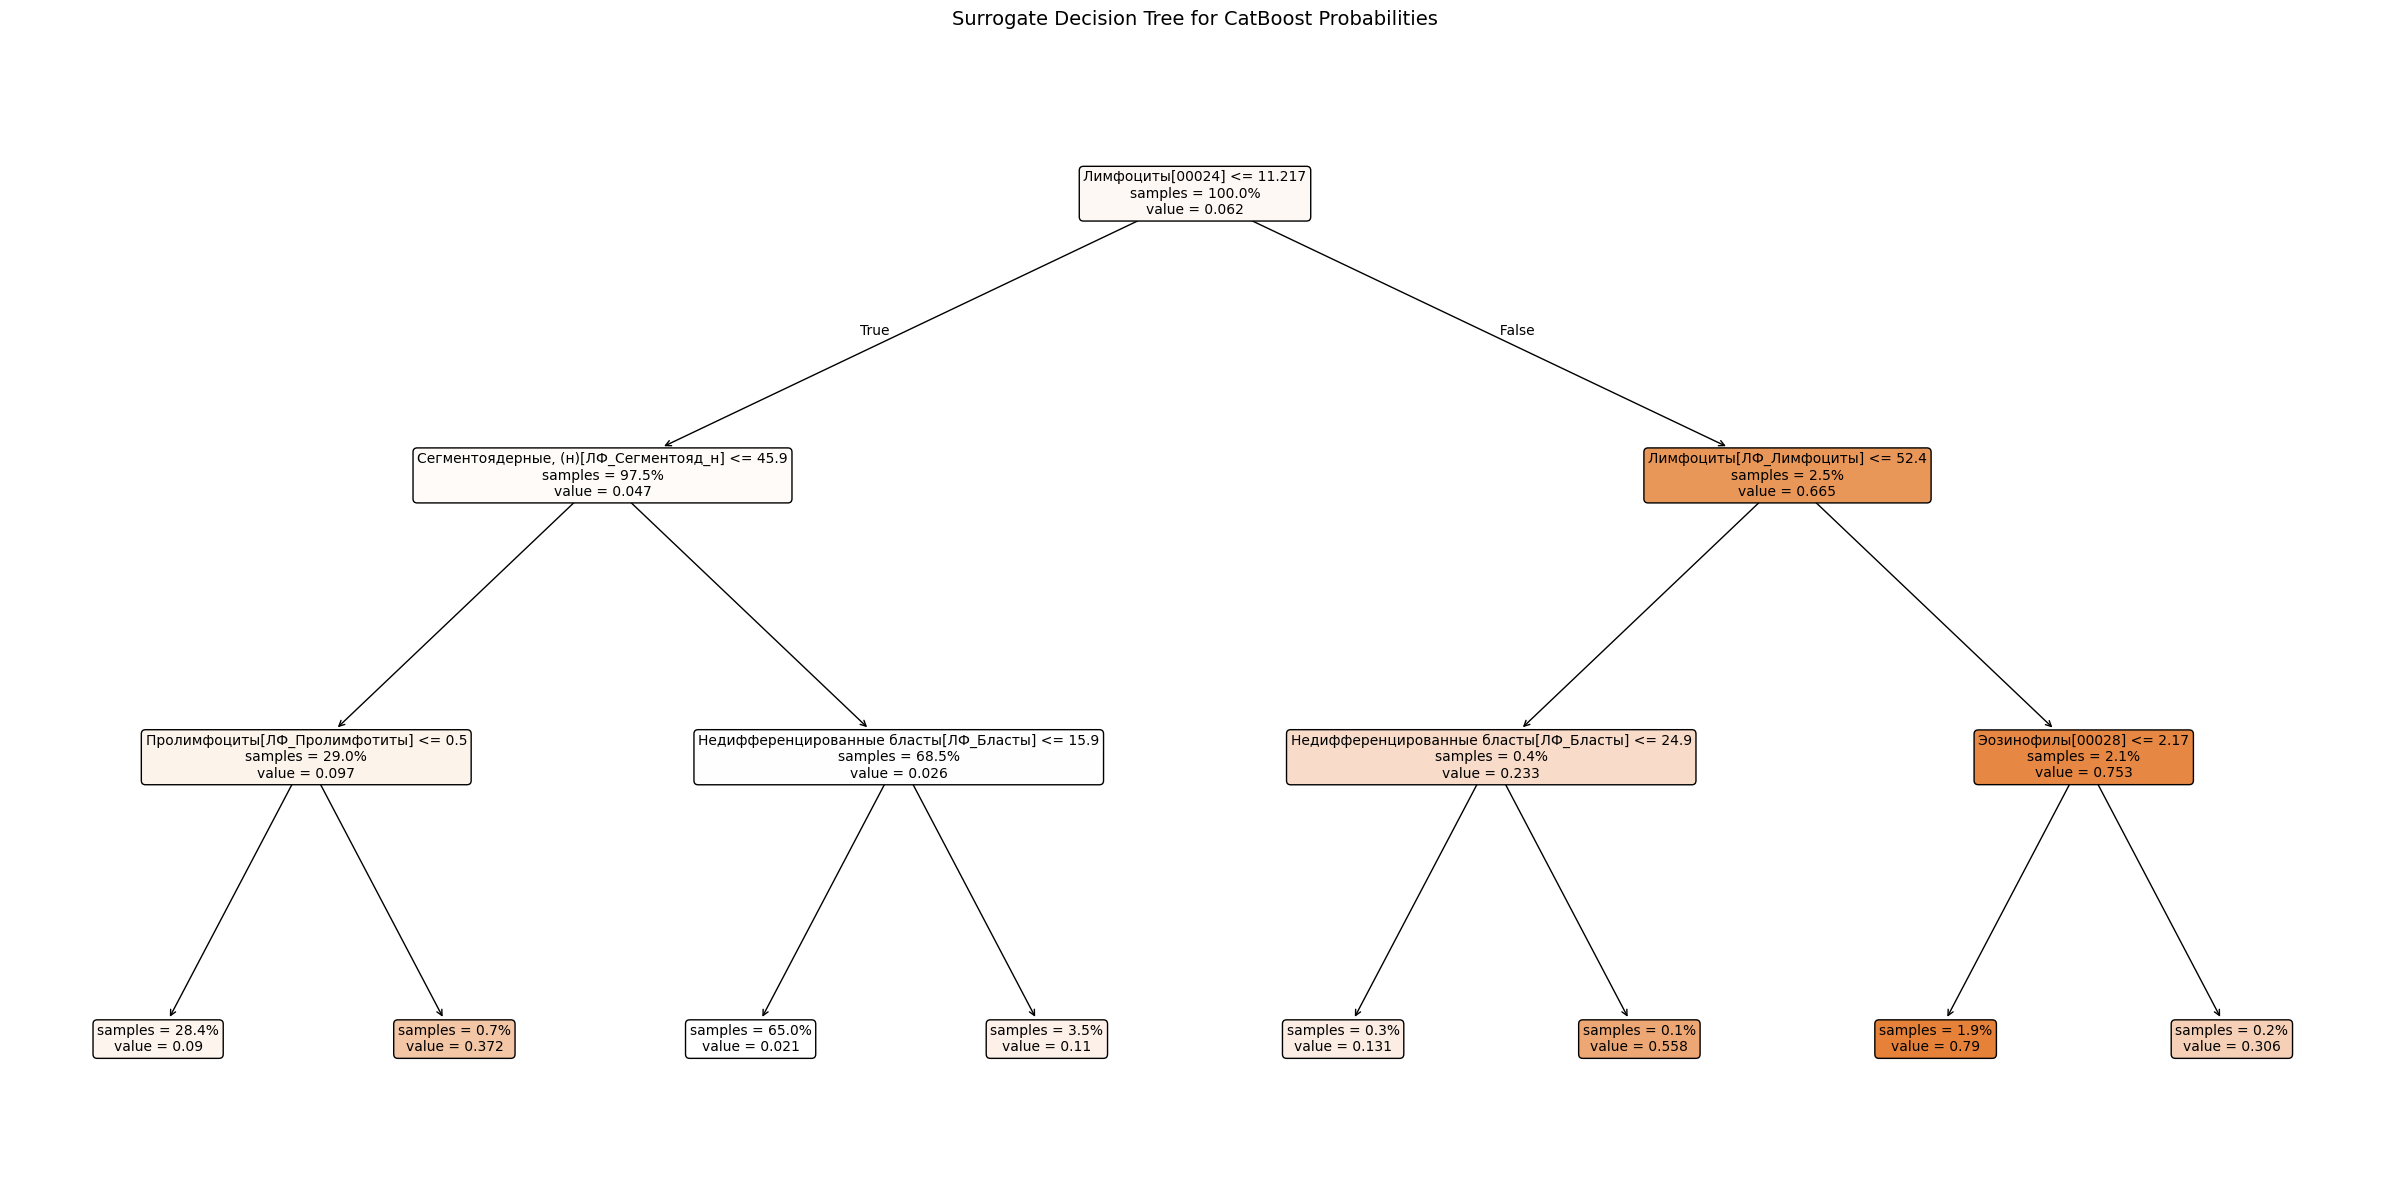

In [36]:
surrogate_tree(X_val_imputed, 5, X_train.drop(["client_id", "диагноз клинический"], axis=1).columns) #class C91 

Undifferentiated blasts and lymphocytes are indeed important for lymphoblastic leukemia

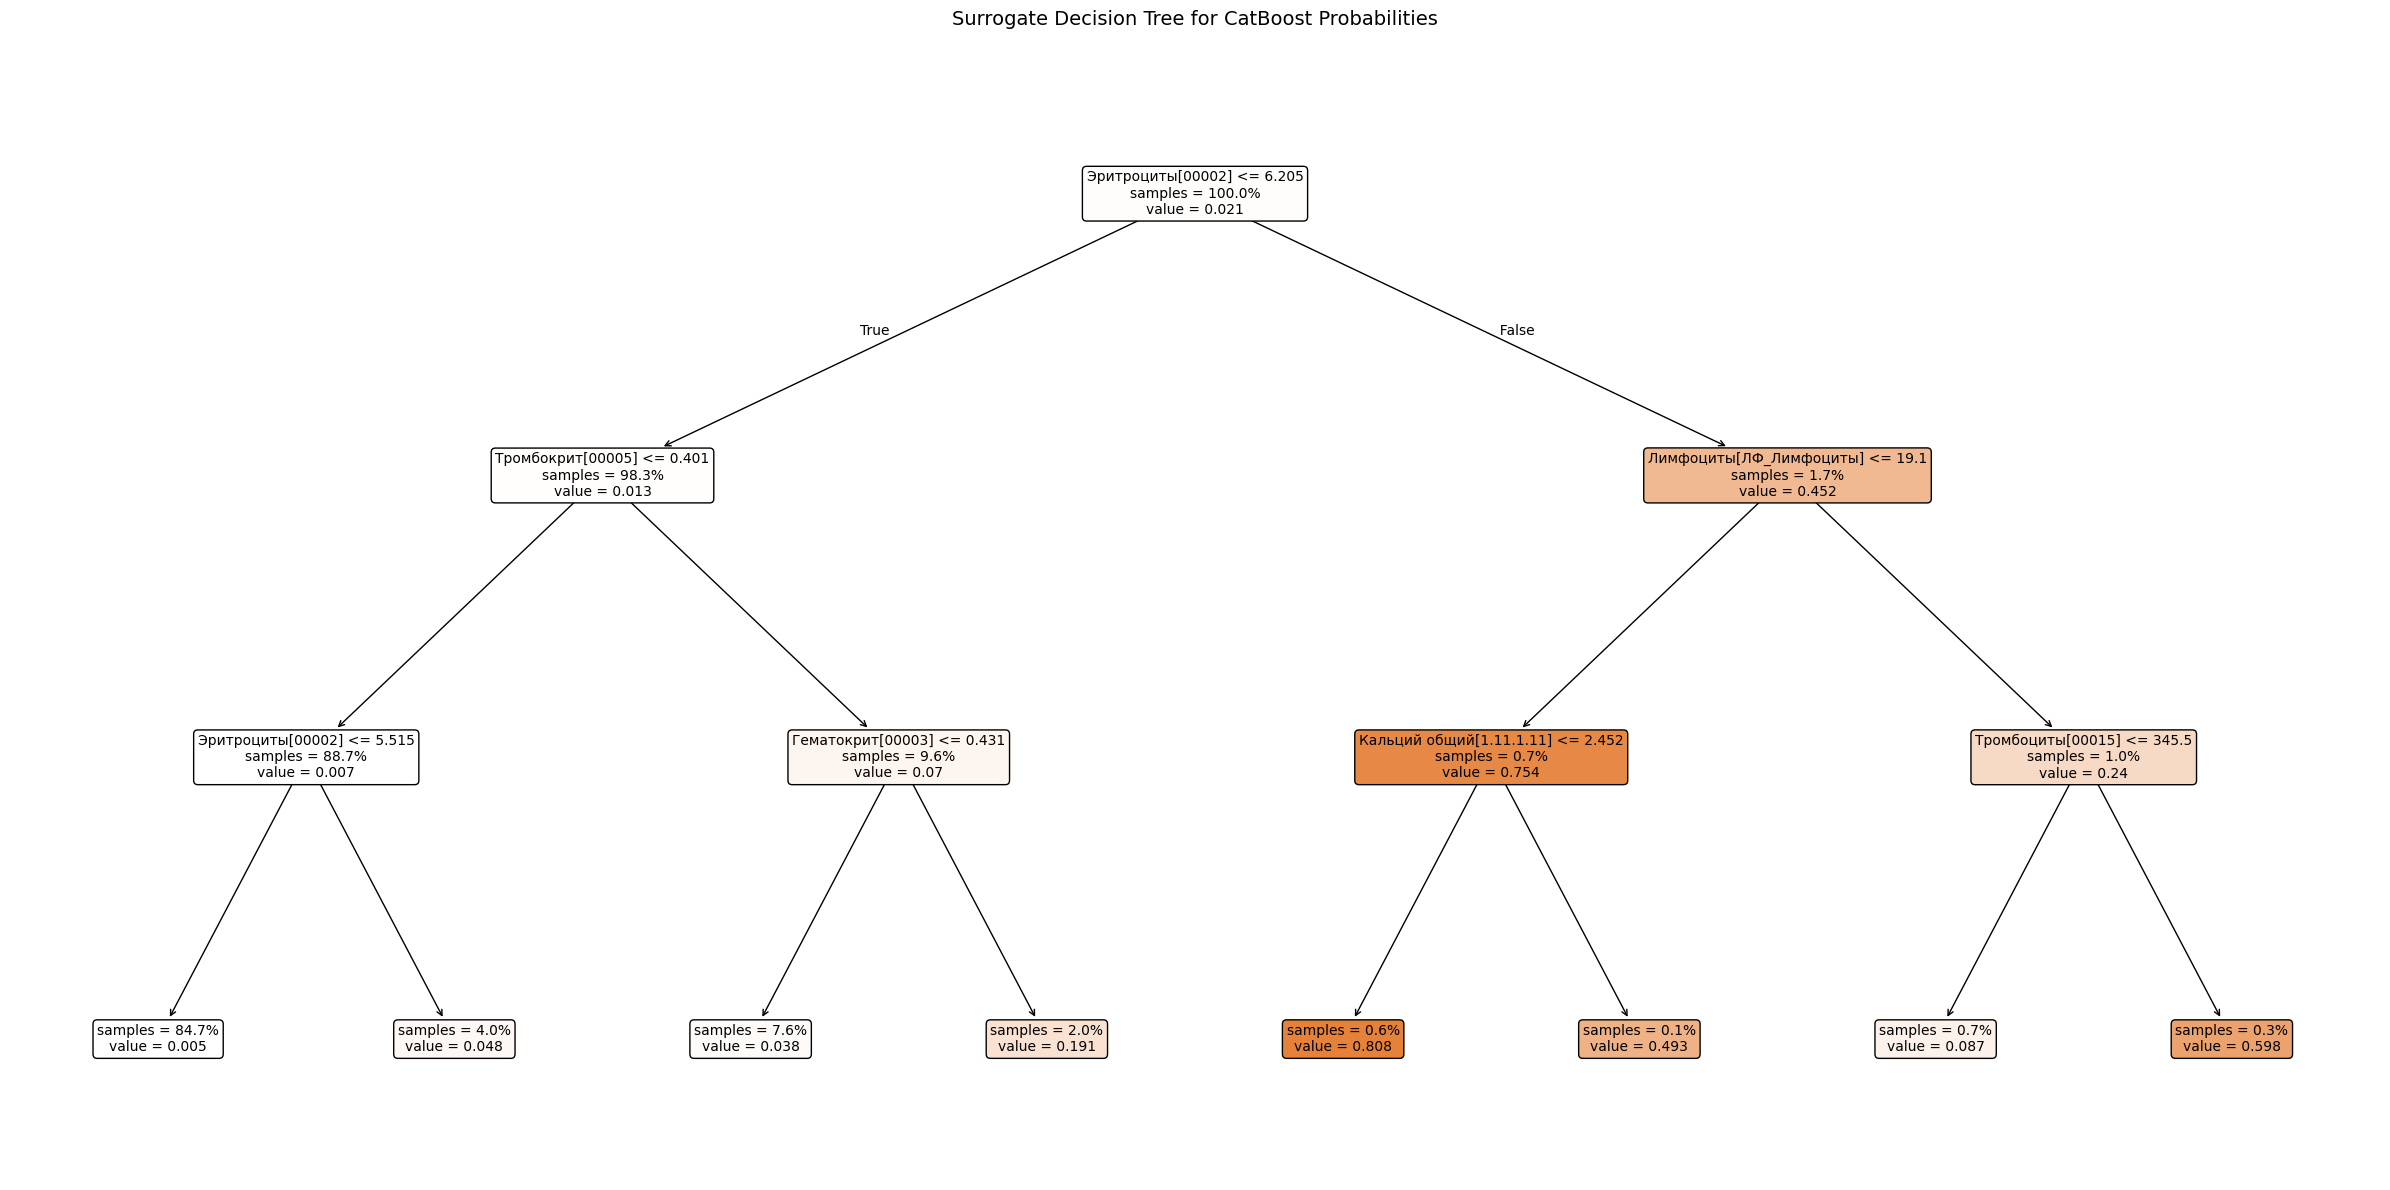

In [38]:
surrogate_tree(X_val_imputed, 7, X_train.drop(["client_id", "диагноз клинический"], axis=1).columns) #class D45

Erythrocytes and lymphocytes should indeed be the deciding factors for polycythemia vera

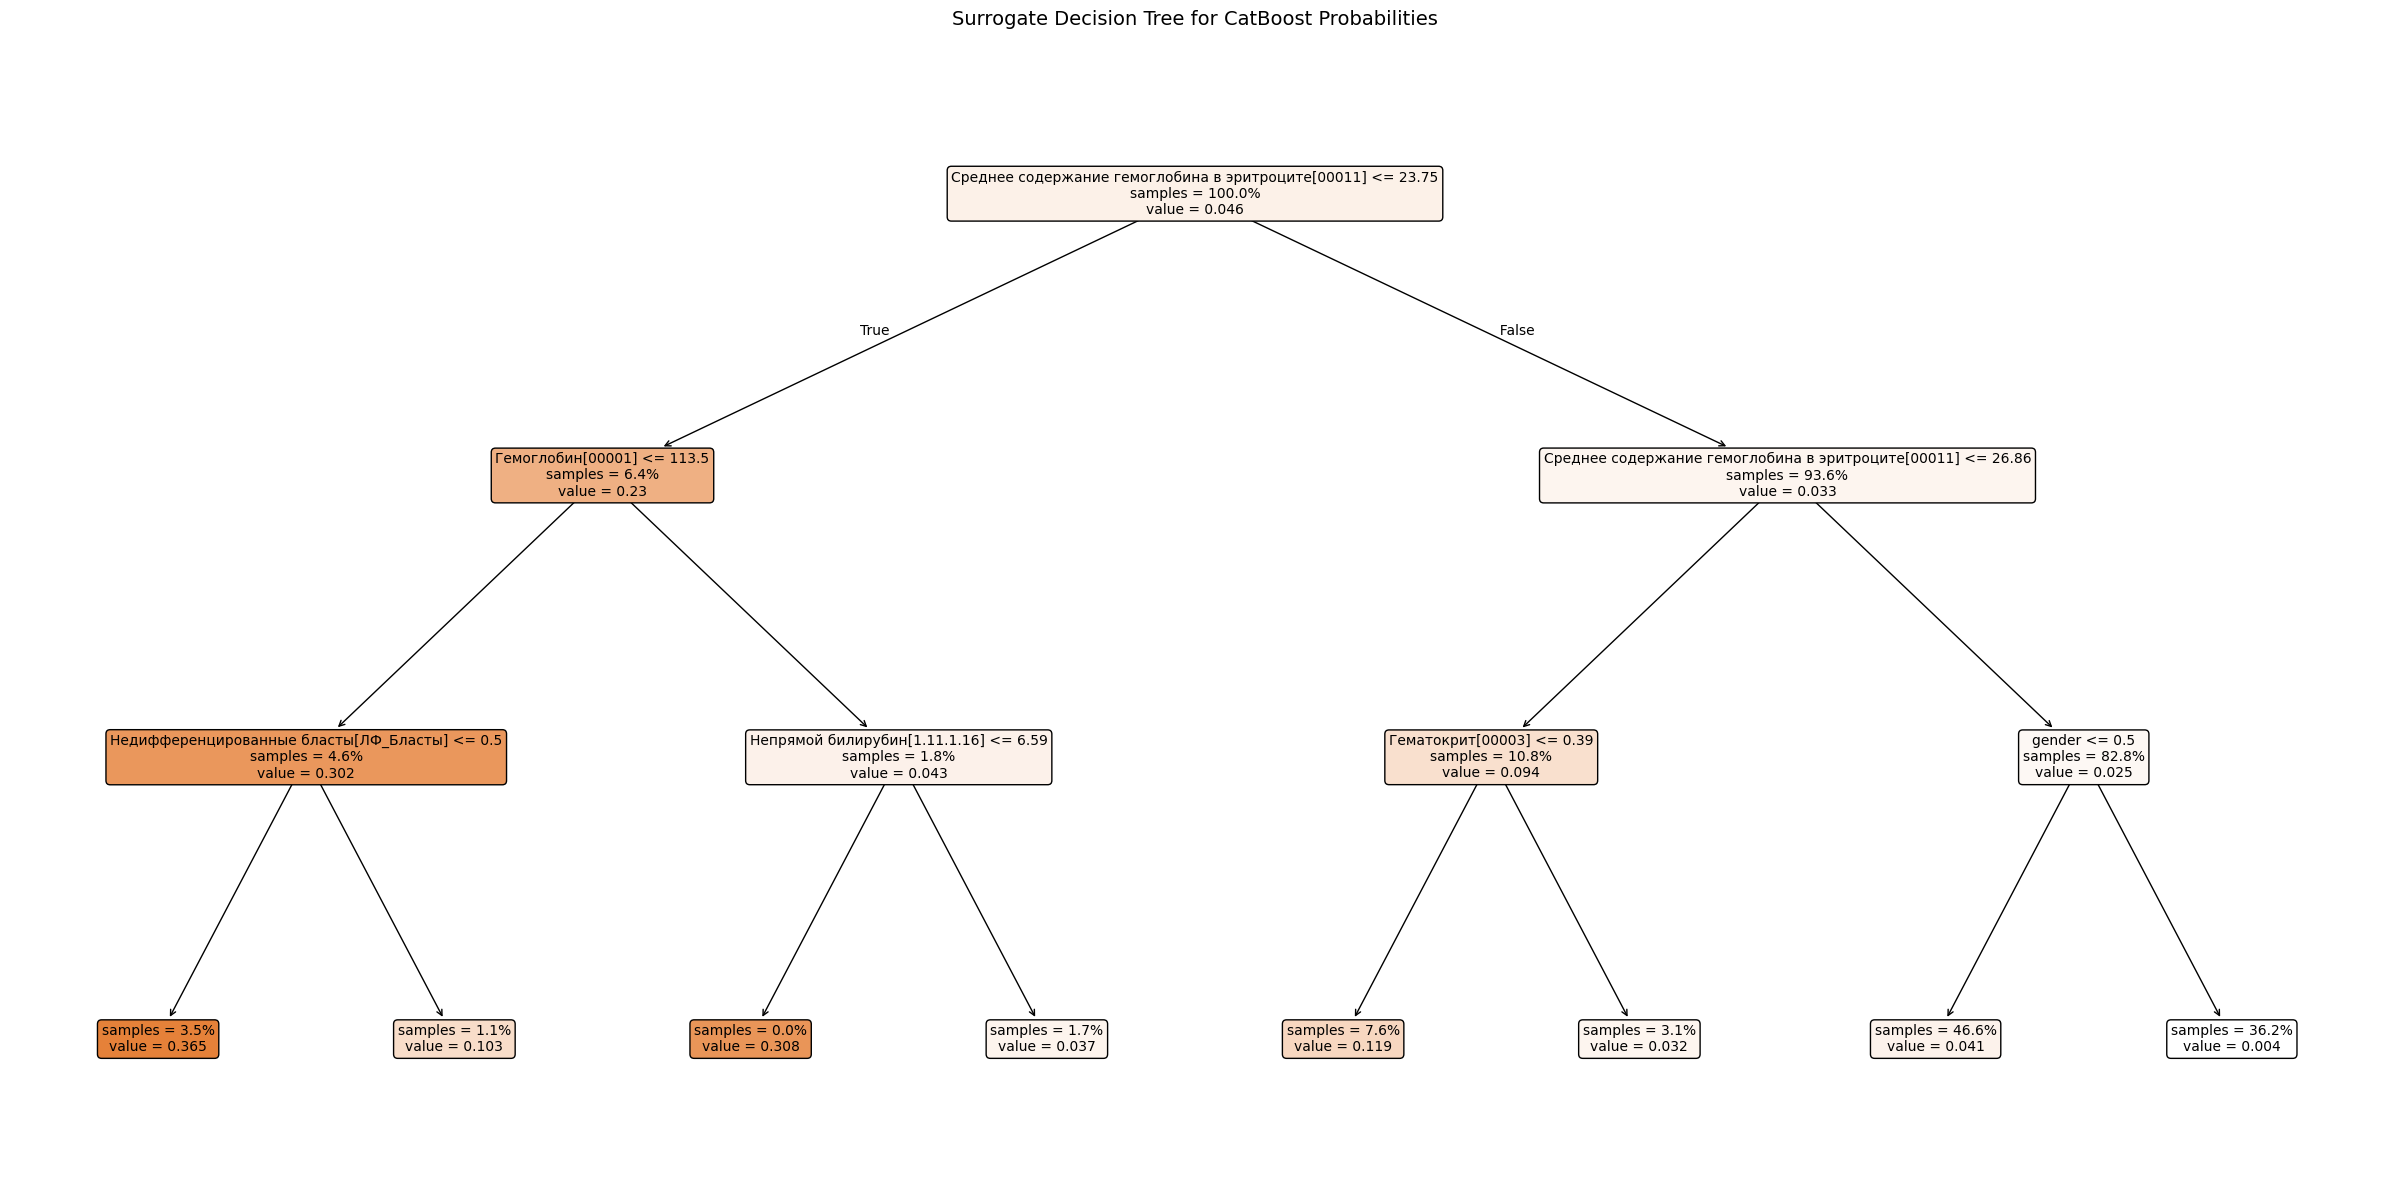

In [43]:
surrogate_tree(X_val_imputed, 10, X_train.drop(["client_id", "диагноз клинический"], axis=1).columns) #class D50 

It is correct to rely on hemoglobin, bilirubin, blasts for anemia

/scratch/ipykernel_3274824/1382351264.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/home/opiskunova/.conda/envs/pandas_openpyxl_env/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 41.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/opiskunova/.conda/envs/pandas_openpyxl_env/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 24.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


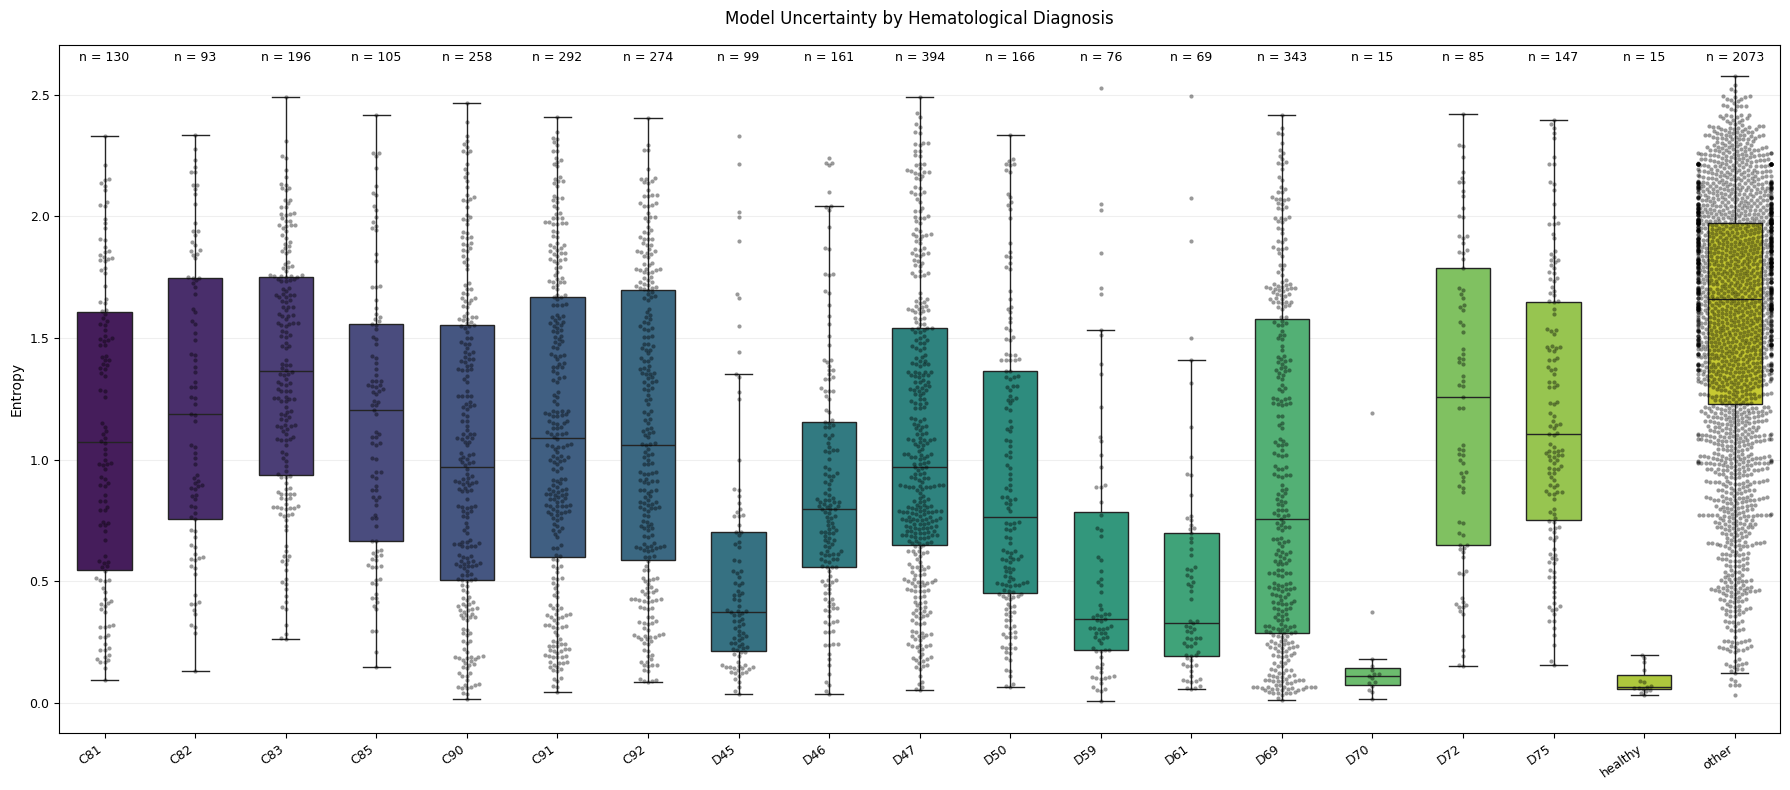

/scratch/ipykernel_3274824/1382351264.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/home/opiskunova/.conda/envs/pandas_openpyxl_env/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/opiskunova/.conda/envs/pandas_openpyxl_env/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 44.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/opiskunova/.conda/envs/pandas_openpyxl_env/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 32.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.

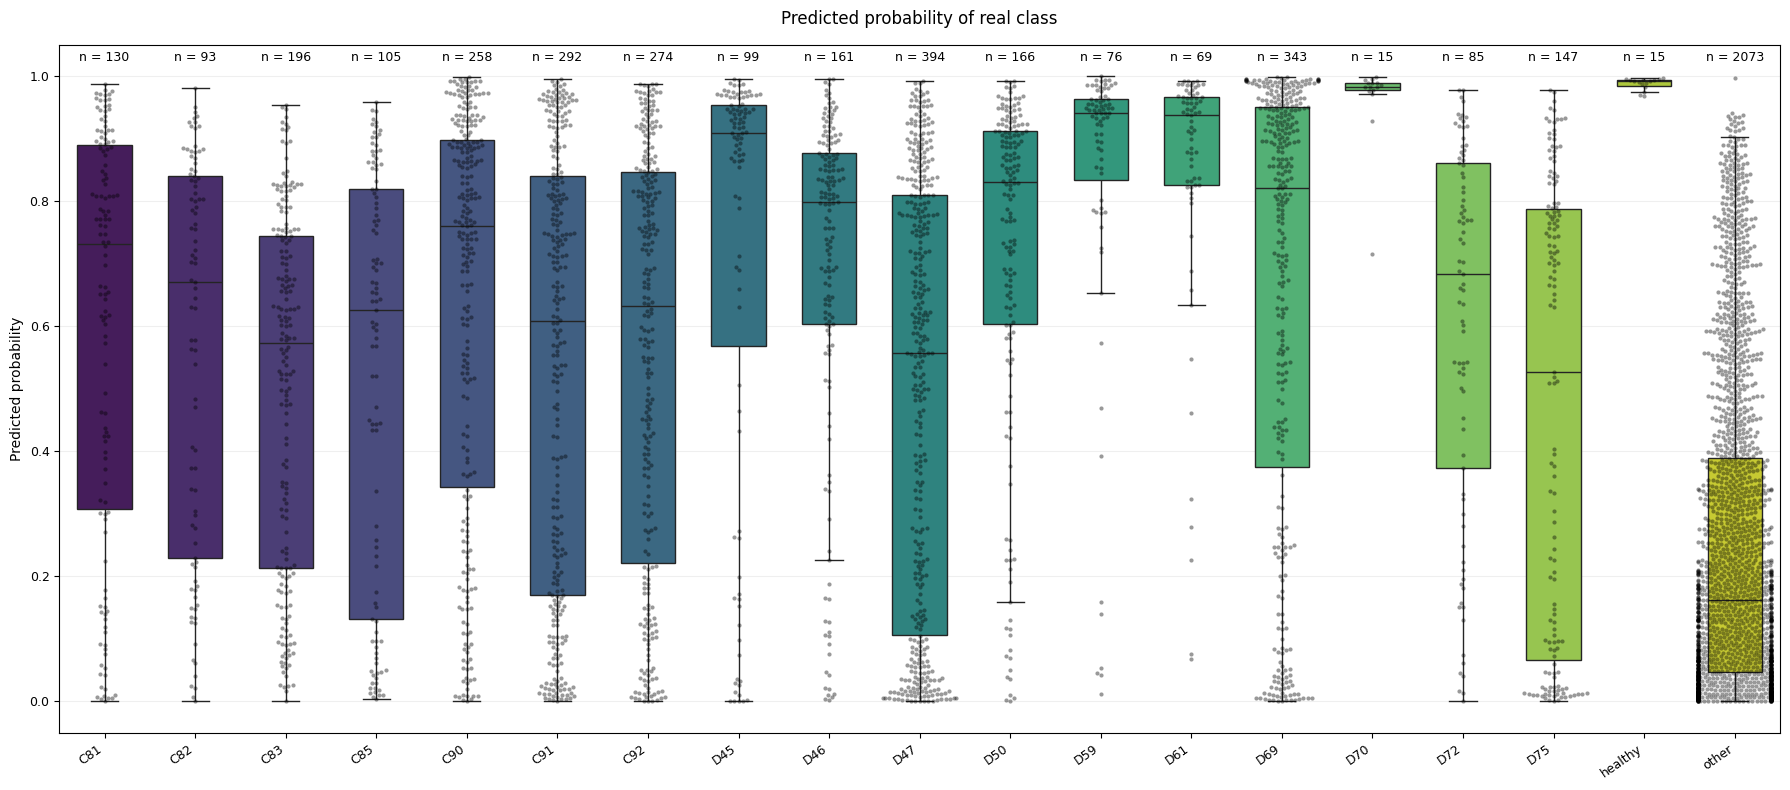

In [31]:
import seaborn as sns
def draw_confidence_boxplots(selected_values, y_val=y_val, title='Model Uncertainty by Hematological Diagnosis', ylabel='Entropy'):
    df_entropies = pd.DataFrame({'values': selected_values, 'True_Class': y_val})

    class_names = dict(zip(np.arange(19), le.classes_))
    df_entropies['Diagnosis'] = df_entropies['True_Class'].map(class_names)

    plt.figure(figsize=(18, 8))
    ax = sns.boxplot(
        data=df_entropies,
        x='Diagnosis',
        y="values",
        order=list(class_names.values()),  
        palette='viridis',
        width=0.6,
        showfliers=False
    )

    sns.swarmplot(
        data=df_entropies,
        x='Diagnosis',
        y='values',
        color='black',
        alpha=0.4,
        size=3
    )

    box_order = [t.get_text() for t in ax.get_xticklabels()]

    for i, diagnosis in enumerate(box_order): 
        n_samples = len(df_entropies[df_entropies['Diagnosis'] == diagnosis])
        ax.text(
            i, 
            ax.get_ylim()[1] * 0.98, 
            f'n = {n_samples}',
            ha='center',
            va='center',
            fontsize=9
        )

    plt.title(title, pad=15, fontsize=12)
    plt.ylabel(ylabel, fontsize=10)
    plt.xlabel('')
    plt.xticks(rotation=35, ha='right', fontsize=9)
    plt.yticks(fontsize=9)
    plt.grid(axis='y', alpha=0.2)
    plt.tight_layout()
    plt.show()



probs = loaded_model.predict_proba(X_val.drop(["client_id", "диагноз клинический"], axis=1))
entropies = -np.sum(np.log(probs) * probs, axis=1)
class_probs = probs[np.arange(len(y_val)), y_val]

draw_confidence_boxplots(entropies)
draw_confidence_boxplots(class_probs, title="Predicted probability of real class", ylabel="Predicted probability")

In [30]:
import scipy.stats as  sps
from statsmodels.stats.multitest import multipletests

pvals_entropies = []
pvals_probs = []

for i in range(19):
    pvalue  = sps.ttest_ind(entropies[np.where(y_val  == 17)[0]], entropies[np.where(y_val  == i)[0]], equal_var=False).pvalue
    pvals_entropies.append(pvalue)

    pvalue  = sps.ttest_ind(entropies[np.where(y_val  == 17)[0]], entropies[np.where(y_val  == i)[0]], equal_var=False).pvalue
    pvals_probs.append(pvalue)

_, adjusted_pvals_entropies, _, _ = multipletests(
    pvals_entropies, 
    alpha=0.05, 
    method='fdr_bh'
)

_, adjusted_pvals_probs, _, _ = multipletests(
    pvals_probs, 
    alpha=0.05, 
    method='fdr_bh'
)

print('entropy:', adjusted_pvals_entropies)
print('probas_p-vals:', adjusted_pvals_probs)

entropy: [2.20484559e-38 4.54820494e-33 1.51483975e-80 1.00674926e-37
 5.79025762e-61 4.44281597e-74 1.75662414e-71 6.55418333e-14
 1.58788416e-43 1.16566718e-83 4.20808081e-40 1.40287776e-10
 8.73477543e-10 3.99399889e-59 2.23820315e-01 1.59270853e-28
 1.30295309e-51 1.00000000e+00 1.78093848e-45]
probas_p-vals: [2.20484559e-38 4.54820494e-33 1.51483975e-80 1.00674926e-37
 5.79025762e-61 4.44281597e-74 1.75662414e-71 6.55418333e-14
 1.58788416e-43 1.16566718e-83 4.20808081e-40 1.40287776e-10
 8.73477543e-10 3.99399889e-59 2.23820315e-01 1.59270853e-28
 1.30295309e-51 1.00000000e+00 1.78093848e-45]


The highest entropy corresponds to the class 'other' which is expected. The lowest entropy and highest confidence corresponds to the class 'healthy' which is a positive sign.
We can distinguish classes with statistical significance.